In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset
from src.renderer import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans

In [65]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"
# dataset = MRIDataset([image_path / t1_file], "T1", axis=0)

In [69]:
dataset = MRIDataset([image_path / t1_file, image_path / t2_file], "Patient 5", axis=0)

T1 = dataset[0]
T1_volume = T1["image"].squeeze(0)       # (D,H,W)
T2 = dataset[1]
T2_volume = T2["image"].squeeze(0)       # (D,H,W)

In [70]:
T1_volume = T1_volume.float()

t1 = np.array([-2.0, -1.0, 0.0,  1.5]).reshape(-1,1)
t2 = np.array([-2.0, -0.5, 0.0,  2.0]).reshape(-1,1)
z1 = np.array([400,  1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)/1e6
z2 = np.array([400,  1.38e6, 1.7e6, 1.52e6]).reshape(-1,1)/1e6

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)
X2 = torch.tensor(t2, dtype=torch.float32)
Y2 = torch.tensor(z2, dtype=torch.float32)

model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
model_t2 = ImpedanceEstimator.train_model(X2, Y2, input_dim=1)

Z_vol = ImpedanceEstimator.compute_impedance_volume(T1_volume, model_t1, threshold=50)

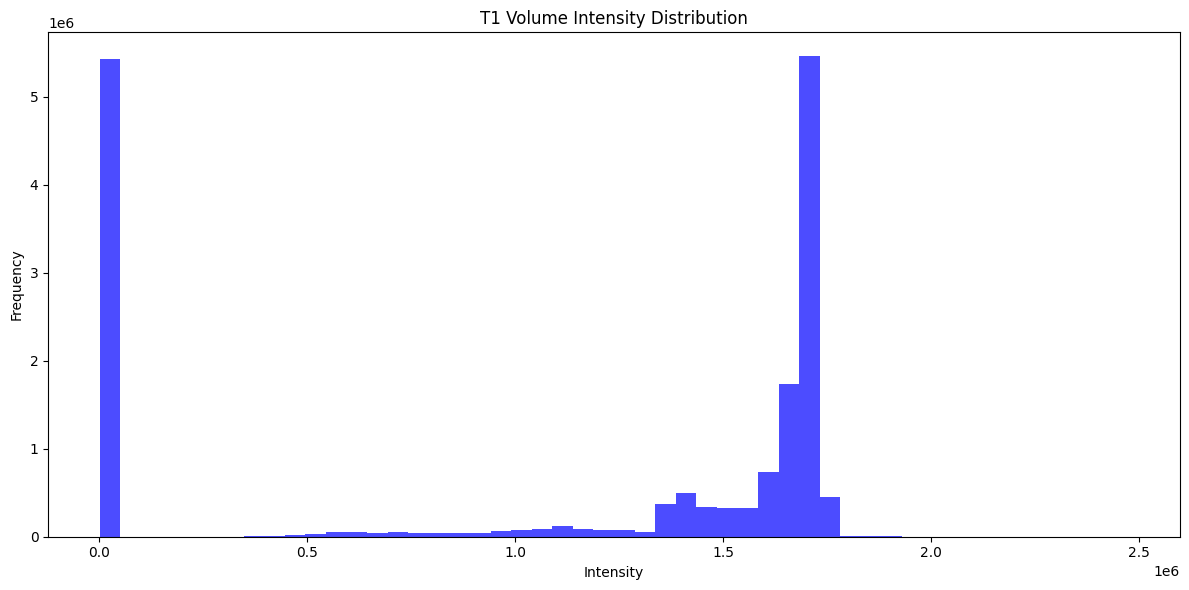

In [71]:
plot_histogram(Z_vol)

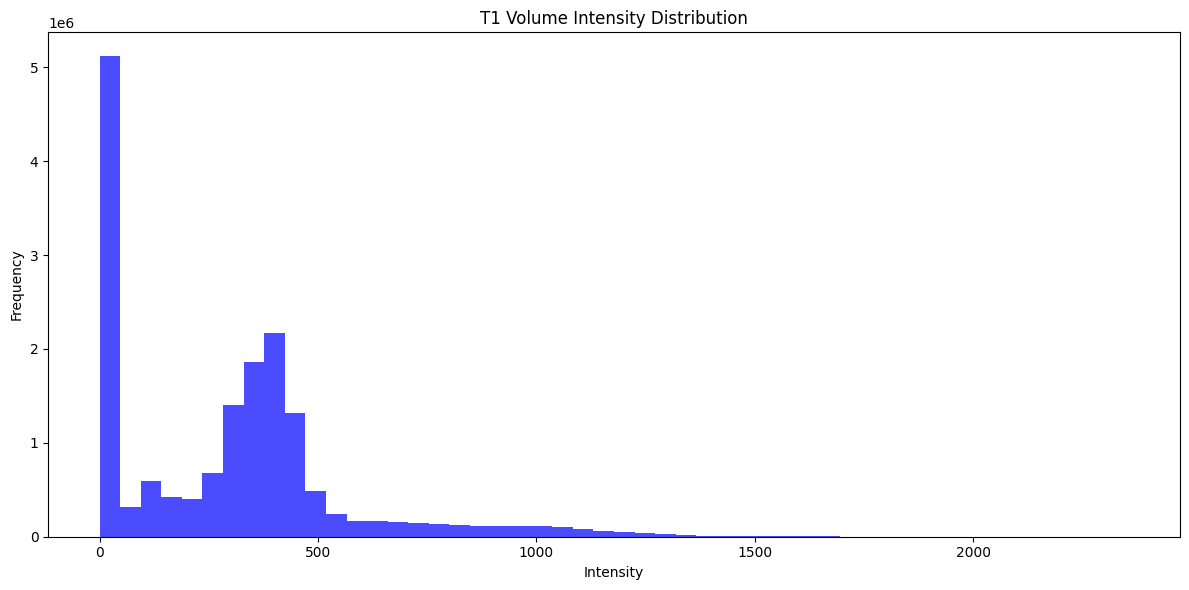

In [72]:
plot_histogram(T1_volume)

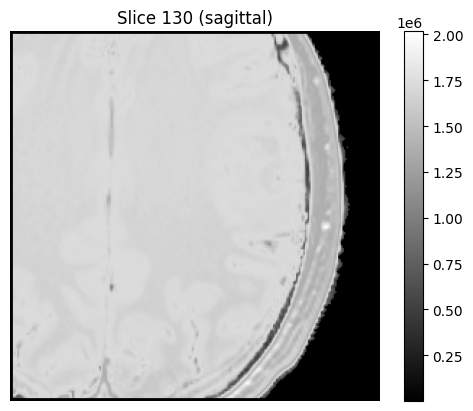

In [76]:
slice_id = 130
axis = 2  # 0: axial, 1: coronal, 2: sagittal

if axis == 0:
    img = Z_vol[slice_id, :, :]
elif axis == 1:
    img = Z_vol[:, slice_id, :]
elif axis == 2:
    img = Z_vol[:, :, slice_id]
else:
    raise ValueError("Axis must be 0 (axial), 1 (coronal), or 2 (sagittal).")

orientation = {0: 'axial', 1: 'coronal', 2: 'sagittal'}.get(axis, 'unknown')

plt.imshow(img.numpy().T, cmap='gray')
plt.title(f"Slice {slice_id} ({orientation})")
plt.axis("off")
plt.colorbar()
plt.show()

In [86]:
directions = torch.tensor([[-0.1058, -0.9944,  0.0000],
        [-0.0913, -0.9958,  0.0000],
        [-0.0768, -0.9970,  0.0000],
        [-0.0623, -0.9981,  0.0000],
        [-0.0478, -0.9989,  0.0000],
        [-0.0333, -0.9994,  0.0000],
        [-0.0188, -0.9998,  0.0000],
        [-0.0042, -1.0000,  0.0000],
        [ 0.0103, -0.9999,  0.0000],
        [ 0.0248, -0.9997,  0.0000],
        [ 0.0394, -0.9992,  0.0000],
        [ 0.0539, -0.9985,  0.0000],
        [ 0.0684, -0.9977,  0.0000],
        [ 0.0829, -0.9966,  0.0000],
        [ 0.0974, -0.9952,  0.0000],
        [ 0.1118, -0.9937,  0.0000],
        [ 0.1263, -0.9920,  0.0000],
        [ 0.1407, -0.9901,  0.0000],
        [ 0.1550, -0.9879,  0.0000],
        [ 0.1694, -0.9856,  0.0000],
        [ 0.1837, -0.9830,  0.0000],
        [ 0.1980, -0.9802,  0.0000],
        [ 0.2122, -0.9772,  0.0000],
        [ 0.2264, -0.9740,  0.0000],
        [ 0.2405, -0.9707,  0.0000],
        [ 0.2546, -0.9671,  0.0000],
        [ 0.2686, -0.9632,  0.0000],
        [ 0.2826, -0.9592,  0.0000],
        [ 0.2965, -0.9550,  0.0000],
        [ 0.3103, -0.9506,  0.0000],
        [ 0.3241, -0.9460,  0.0000],
        [ 0.3378, -0.9412,  0.0000],
        [ 0.3515, -0.9362,  0.0000],
        [ 0.3651, -0.9310,  0.0000],
        [ 0.3786, -0.9256,  0.0000],
        [ 0.3920, -0.9200,  0.0000],
        [ 0.4053, -0.9142,  0.0000],
        [ 0.4185, -0.9082,  0.0000],
        [ 0.4317, -0.9020,  0.0000],
        [ 0.4448, -0.8956,  0.0000],
        [ 0.4577, -0.8891,  0.0000],
        [ 0.4706, -0.8823,  0.0000],
        [ 0.4834, -0.8754,  0.0000],
        [ 0.4961, -0.8683,  0.0000],
        [ 0.5086, -0.8610,  0.0000],
        [ 0.5211, -0.8535,  0.0000],
        [ 0.5334, -0.8458,  0.0000],
        [ 0.5457, -0.8380,  0.0000],
        [ 0.5578, -0.8300,  0.0000],
        [ 0.5698, -0.8218,  0.0000],
        [ 0.5817, -0.8134,  0.0000],
        [ 0.5935, -0.8049,  0.0000],
        [ 0.6051, -0.7962,  0.0000],
        [ 0.6166, -0.7873,  0.0000],
        [ 0.6280, -0.7782,  0.0000],
        [ 0.6392, -0.7690,  0.0000],
        [ 0.6503, -0.7596,  0.0000],
        [ 0.6613, -0.7501,  0.0000],
        [ 0.6721, -0.7404,  0.0000],
        [ 0.6828, -0.7306,  0.0000],
        [ 0.6934, -0.7206,  0.0000],
        [ 0.7038, -0.7104,  0.0000],
        [ 0.7140, -0.7001,  0.0000],
        [ 0.7241, -0.6897,  0.0000]])

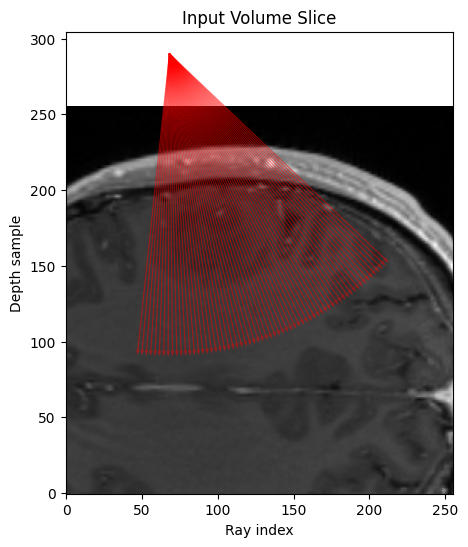

In [89]:
UR = UltrasoundRenderer(200, 0.0001)

angle = 45  # degrees
rays = 150

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
source = np.array([290, 68, 130])  # source position
# directions = [np.array([np.sin(theta), np.cos(theta), 0]) for theta in thetas]
# directions = torch.tensor(directions, dtype=torch.float32)  # (rays, 3)

img = T1_volume[:,:, 130].T 

ax = UR.plot_frame(img)
ax.imshow(img.T, origin="lower", cmap='gray')

N = directions.shape[0]
starts_x = np.full(N, source[1])  # x coordinate of the source  
starts_y = np.full(N, source[0])  # y coordinate of the source

dx = directions[:, 0]  # previously z becomes new x
dy = directions[:, 1]  # previously x becomes new y

ax.quiver(
    starts_x, starts_y,
    dx, dy,
    angles='xy', scale_units='xy', scale=1/UR.num_samples,
    color='red', width=0.003, alpha=0.5
)


In [ ]:
Z_vol[:, :, source[2]].T, T1_volume[:, :, source[2]].T

(tensor([[4.0000e+02, 4.0000e+02, 4.0000e+02,  ..., 4.0000e+02, 4.0000e+02,
          4.0000e+02],
         [4.0000e+02, 4.0000e+02, 4.0000e+02,  ..., 4.0000e+02, 4.0000e+02,
          4.0000e+02],
         [4.0000e+02, 4.0000e+02, 1.7241e+06,  ..., 4.0000e+02, 4.0000e+02,
          4.0000e+02],
         ...,
         [4.0000e+02, 4.0000e+02, 9.6556e+05,  ..., 4.0000e+02, 4.0000e+02,
          4.0000e+02],
         [4.0000e+02, 4.0000e+02, 4.0000e+02,  ..., 4.0000e+02, 4.0000e+02,
          4.0000e+02],
         [4.0000e+02, 4.0000e+02, 4.0000e+02,  ..., 4.0000e+02, 4.0000e+02,
          4.0000e+02]]),
 tensor([[368., 362., 349.,  ...,   7.,   8.,  10.],
         [371., 360., 354.,  ...,   6.,   9.,  13.],
         [378., 358., 362.,  ...,   5.,   7.,  10.],
         ...,
         [105.,  96., 111.,  ...,   4.,   4.,   4.],
         [219., 169., 156.,  ...,   4.,   6.,   6.],
         [453., 362., 293.,  ...,   4.,   7.,   8.]]))

Some fuck up with this???

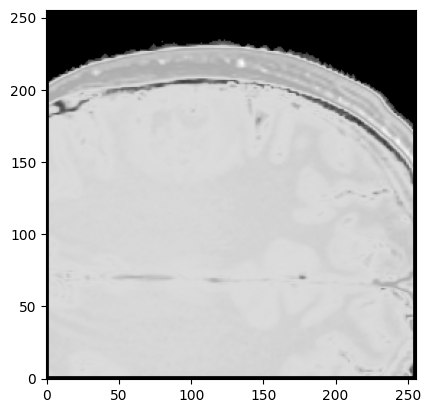

In [92]:
# Z_vol[:,:, ]
plt.imshow(Z_vol[:,:, source[2]], cmap='gray', origin='lower')

[INFO] Tracing rays with source: tensor([290,  68, 130]) and directions shape: torch.Size([64, 1, 3])
Intensity range: 0.0000 to 0.0000


matplotlib.collections.PathCollection

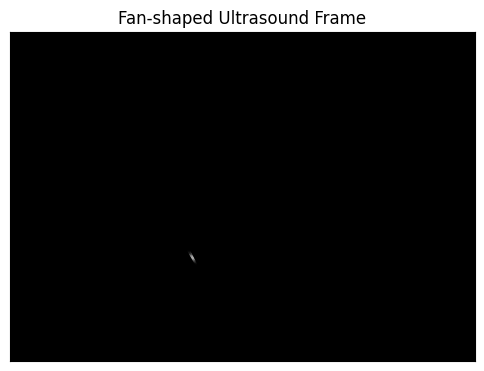

In [97]:
intensities = UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor(source),
    directions=directions,
    artifacts=False,
    angle=angle,
    start=0
)
type(intensities[1])

C:\Users\noe\AppData\Local\Temp\ipykernel_18824\2345216156.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



[INFO] Starting from sample index: 80 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 80 (150, 201)
Intensity range: 0.0000 to 0.3458


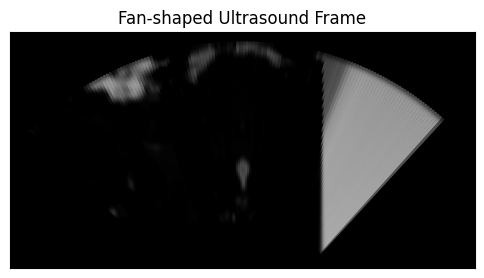

In [16]:
output, _ = UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor(source),
    directions=torch.tensor(directions),
    artifacts=False,
    angle=angle,
    start=80
)


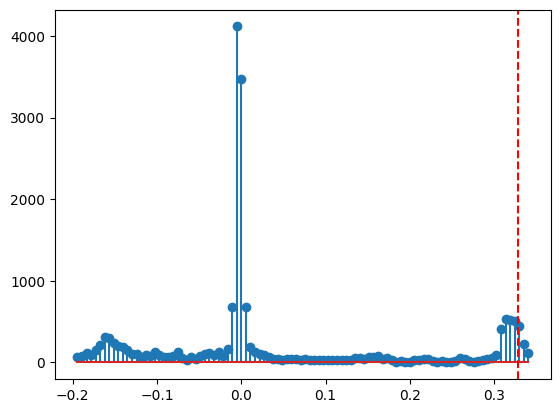

In [17]:
hist, bins = np.histogram(output.flatten(), bins=100)

plt.stem(bins[:-1], hist)
# get 15% 
threshold = np.percentile(output.flatten(), 95)
plt.axvline(threshold, color='red', linestyle='--')